In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
abstracts = pd.read_csv('../data/abstracts_df.csv', index_col=0)

In [4]:
abstracts.head()

,abstract
0,\n1. Bone. 2018 Sep 24. pii: S8756-3282(18)303...
1,\n\n\n2. Neurosci Lett. 2018 Sep 24. pii: S03...
2,\n\n\n3. Antivir Ther. 2018 Sep 27. doi: 10.3...
3,\n\n\n4. Fetal Pediatr Pathol. 2018 Sep 27:1-...
4,\n\n\n5. Clin Exp Immunol. 2018 Oct;194(1):17...


### removing short abstracts
- very old abstracts (from the beginning of the 20th centuries) are only indexed and do not contain an abstract, just a title and authors
    - have no valuable information
    - can be cut by removing abstracts that don't meet a certain length
- the column with the abstract lengths is dropped at the end because it is not needed anymore

In [5]:
abstracts['abstract_length'] = abstracts.abstract.str.len()

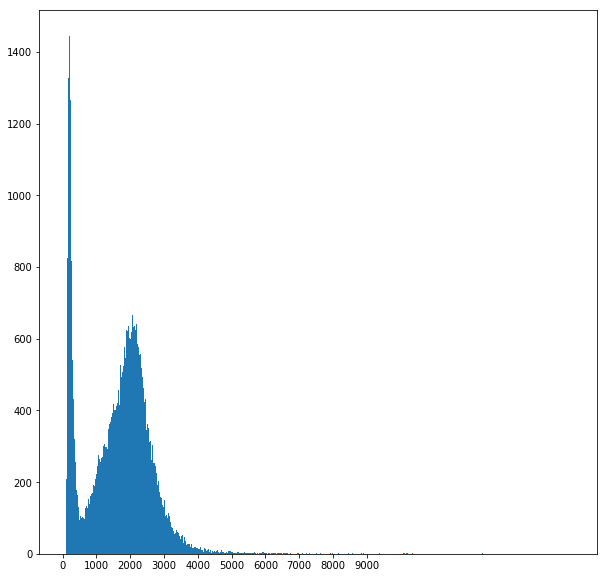

In [6]:
plt.figure(figsize=(10,10))
plt.hist(abstracts['abstract_length'], bins=1000)
plt.xticks(np.arange(0, 10000, 1000.0))
plt.show()

There are so many extremely short abstracts that a big peak is obvious. This peak needs to be removed. Cut-off is set at a minimum length of 500 characters.

In [7]:
abstracts = abstracts[abstracts['abstract_length'] > 500]
abstracts.drop('abstract_length', axis=1, inplace=True)

### Formatting the abstracts
- the numbering is removed
- the new lines are removed

In [8]:
# remove numbering (for details see file 'text_to_dataframe')
abstracts['abstract'] = abstracts['abstract'].str.replace('(\n+\d+\.)', '')

# whitespaces in the beginning are stripped
abstracts['abstract'] = abstracts['abstract'].str.lstrip()

In [9]:
abstracts['abstract'] = abstracts['abstract'].str.replace('\n+', ' ')
abstracts['abstract'] = abstracts['abstract'].str.replace('\s+', ' ')

### Getting only the abstracts that contain signifi*
- signifi* = significance, significant, significantly
- since significa* can start with a capital letter, all letters are made lower case
- every row with the abstract containing a variation of signifi* is pulled
- abstracts that just contain "significance:" as to explain the significance of the paper and not the results are removed

In [10]:
abstracts['abstract'] = abstracts['abstract'].str.lower()
abstracts = abstracts[abstracts.abstract.str.contains('signifi\D+') == True]
print(f'Number of abstracts: {len(abstracts)}')

Number of abstracts: 25083


In [11]:
abstracts = abstracts[abstracts.abstract.str.contains('significance:') == False]
print(f'Remaining abstracts: {len(abstracts)}')

Remaining abstracts: 24982


In [12]:
abstracts.reset_index(drop=True, inplace=True)

### Labeling the abstracts
- possible labels for 'significant' are: 'yes', 'no', 'both'
- filters are used to label as many abstracts as possible
    - no/not/non-signifi* are labelled as 'no'
    - unlabelled abstracts are checked by hand to generate the filter for 'yes'
    - filter for 'yes' and 'no' are combined to gererate fileter for 'both'
- the labelled data will be used to train a model, to predict the labels for the unlabelled data

In [13]:
abstracts['significant'] = np.zeros((len(abstracts), 1))

In [14]:
no = r'no signifi|not signifi|non-signifi|did not vary signifi|any signifi|not statistically signifi|without signifi'
abstracts['significant'][abstracts['abstract'].str.contains(no)] = 'no'

In [15]:
yes = r'were signific|a signifi|was signifi|highly signifi|very signifi|significantly \D+ed\
|more signifi|most signifi|less signifi|\D+ed signifi\D+|direct signifi|signifi\D+ associat\D+|\D+s signifi'
abstracts['significant'][abstracts['abstract'].str.contains(yes)] = 'yes'

In [16]:
abstracts['significant'][(abstracts['abstract'].str.contains(yes)) & (abstracts['abstract'].str.contains(no))] = 'both'

### Result of by-hand labelling

In [17]:
abstracts.groupby('significant').count()

,abstract
significant,
0.0,3625
both,4203
no,2013
yes,15141


In [18]:
print(f'{len(abstracts)-3625} abstracts ({np.round((len(abstracts)-3625)/len(abstracts)*100)}) could succesfully be \
labelled succesfully')
print(f'3625 abstracts ({np.round(3625/len(abstracts)*100)}) could not be labelled')

21357 abstracts (85.0) could succesfully be labelled succesfully
3625 abstracts (15.0) could not be labelled
